# 识别手写体/印刷体数字的分类器 #
reference https://lhy.io/digit_recognition/ 
dataset http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

In [1]:
from helper import *
import tensorflow as tf
import os

imgDir = '../../data/EnglishFnt/'

def shuffleData(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices,:,:,:]
    y = y[indices]
    sep = int(0.8 * len(X))
    x_train = X[:sep,:,:,:]
    y_train = y[:sep]
    x_test = X[sep:,:,:]
    y_test = y[sep:]
    return (x_train, y_train), (x_test, y_test)

def gray2binary(gray, threshold):
    bw = gray
    idx1 = gray <= threshold
    idx2 = gray >= threshold
    bw[idx1] = 255
    bw[idx2] = 0
    return bw

## load printed dataset ##

In [48]:
# original size
# nh = 128, nw = 128
nh = 24 
nw = 24

def load_and_rescale(imgDir, nh, nw):

    data = []
    label = []

    for s in os.listdir(imgDir):
        if s[6:].isdigit():
            y = int(s[6:])
        else:
            continue
        if (y == 4 or y > 5):
            continue
        subdir = os.path.join(imgDir, s)
        samples = load_image_png(subdir, nh, nw)
        t = np.ones(len(samples), dtype=np.uint8) * (y - 1)
        data.append(samples)
        label.append(t)
        print(samples.shape)

    data = np.array(data)
    data = np.reshape(data, (1016 * 4, nh, nw, 1))

    label = np.array(label)
    label = np.reshape(label, 1016 * 4)

    data = gray2binary(data, 127)
    data = data / 255.0
    
    return data, label


def expand(image, nx, ny):
    n, nw, nh, nc = image.shape
    result = np.zeros((n, nw + 2 * nx, nh + 2 * ny, nc))
    result[:, nx:nx+nw, ny:ny+nw, :] = image
    return result

data1, label1 = load_and_rescale(imgDir, nh, nw)
data2, label2 = load_and_rescale(imgDir, 18, 18)
data2 = expand(data2, 3, 3)

data = np.concatenate((data1, data2), axis=0)
label = np.hstack((label1, label2))

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)
(1016, 18, 18)
(1016, 18, 18)
(1016, 18, 18)
(1016, 18, 18)


(4064, 24, 24, 1)
(8128, 24, 24, 1)
(8128,)


## 扩充数据集 ##

In [50]:
# 数据集扩充
# 平移
nh = 24
nw = 24
shift = 4

def augment_scale(x, y):
    data = np.array(x.shape)
    label = np.tilt(y, 2)
    

def augment_translate(x, y):

    data, label = x, y
    n = len(data)

    for i in range(-2, 3):
        kx = i * shift
        if kx >= 0:
            ix1, ix2 = 0, nh - kx
        else:
            ix1, ix2 = -kx, nh
        jx1, jx2 = ix1 + kx, ix2 + kx

        for j in range(-2, 3):
            if i == 0 and j == 0:
                continue
            #if abs(i) == 2 and abs(j) == 2:
            #    continue

            ky = j * shift
            if ky >= 0:
                iy1, iy2 = 0, nw - ky
            else:
                iy1, iy2 = -ky, nw
            jy1, jy2 = iy1 + ky, iy2 + ky

            augdata = np.zeros((n, nh, nw, 1))
            augdata[:, ix1:ix2, iy1:iy2, :] = data[:n, jx1:jx2, jy1:jy2, :]

            augy = label[:n]

            data = np.concatenate((data, augdata), axis=0)
            label = np.hstack((label, augy))   
            
    return data, label

data, label = augment_translate(data, label)

In [51]:
print(data.shape)
print(data.shape, label.shape)
print(label)

(203200, 24, 24, 1)
(203200, 24, 24, 1) (203200,)
[0 0 0 ... 4 4 4]


In [52]:
print(np.min(data), np.max(data))

samples = data
(x_train, y_train),(x_test, y_test) = shuffleData(samples, label)

0.0 1.0


## load handwrite digit dataset & merge ##

In [6]:
from load_mnist import loadmnist
(x1_train, y1_train),(x1_test, y1_test) = loadmnist()

print(x_train.shape, y_train.shape)
print(x1_train.shape, y1_train.shape)

(68275, 24, 24, 1) (68275,)
(24465, 28, 28) (24465,)


In [53]:
label_train = y_train.copy()
y_train[label_train == 4] = 3

label_test = y_test.copy()
y_test[label_test == 4] = 3

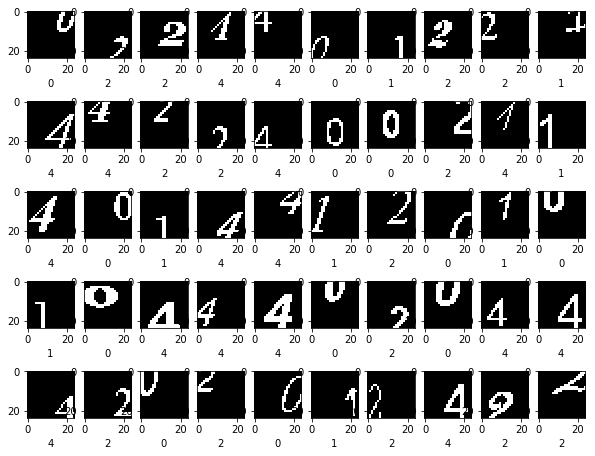

In [54]:
import random
import matplotlib.pyplot as plt

fm = 5
fn = 10

plt.figure(figsize=(10, 8))

for i in range(fm):
    for j in range(fn):

        k = random.randint(0, len(y_test))
        pic = np.reshape(x_test[k, :, :, :], (nh, nh))

        plt.subplot(fm, fn, i * fn + j + 1)
        plt.imshow(pic, cmap='gray')
        plt.xlabel(label_test[k])
    
plt.show()

## create deep models ##

In [55]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout

def create_model_1():
    input_tensor = Input(shape=(128, nh, nw, 1), name="input")
    x = Flatten()(input_tensor)
    x = Dense(16, activation=tf.nn.relu)(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation=tf.nn.relu)(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation=tf.nn.softmax)(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

    
def create_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(24, 24, 1)),
      tf.keras.layers.Dense(16, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(4, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def create_model_c():
    model_c = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(24, 24, 1)),
      tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
      #tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(4, activation=tf.nn.softmax)
    ])
    model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_c 

create_model().summary()
create_model_c().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                9232      
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 132       
Total params: 9,908
Trainable params: 9,908
Non-trainable params: 0
_________________________________________________________________
________

## train DNN model ##

In [14]:
model = create_model()
model.summary()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

model.fit(x_train, y_train, batch_size=64, epochs=20, callbacks = [cp_callback])
model.evaluate(x_test, y_test)

model.save('model.h5')

Epoch 1/20
68275/68275 [==============================] - 2s 33us/step - loss: 0.8080 - acc: 0.6758

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/20
68275/68275 [==============================] - 2s 29us/step - loss: 0.5128 - acc: 0.8123

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/20
68275/68275 [==============================] - 2s 29us/step - loss: 0.4517 - acc: 0.8333

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/20
68275/68275 [==============================] - 2s 30us/step - loss: 0.4206 - acc: 0.8441

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/20
68275/68275 [==============================] - 2s 29us/step - loss: 0.4055 - acc: 0.8493

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/20
68275/68275 [==============================] - 2s 29us/step - loss: 0.3872 - acc: 0.8562

Epoch 00006: saving model to training_1/cp.ckpt
Epoch 7/20
68275/68275 [==============================] - 2s 29us/step - loss: 0.3790 - acc: 0.8603

Epoch

(68275, 24, 24, 1)


## train a CNN model ##

save and restore models
https://www.tensorflow.org/tutorials/keras/save_and_restore_models

In [61]:
model_c = create_model_c()
model_c.summary()

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

model_c.fit(x_train, y_train, batch_size=64, epochs=20, callbacks = [cp_callback])
model_c.evaluate(x_test, y_test)

# save the entire model
model_c.save('model_c.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 22, 22, 8)         80        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 16)        1168      
_________________________________________________________________
flatten_23 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 25604     
Total params: 26,852
Trainable params: 26,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
162560/162560 [==============================] - 37s 231us/step - loss: 0.3464 - acc: 0.8895

Epoch 00001: saving model to training_2/cp.ckpt
Epoch 2/20
162560/162560 [==============================] - 37s 226us/step - loss: 0.1537 - acc: 0.9531

Epoch 00002:

In [114]:
print(np.min(x_test), np.max(x_test))

0.0 1.0


# TEST DATA #
collect from small vehicle

In [57]:
gc = 127
nh = 24
nw = 32

samples, label = load_image_x("./test", nh, nw)

n = len(label)

x_real = preprocess(samples, 4, 127)
x_real = np.reshape(x_real, (n, nh, nh, 1))
y_real = label
y_real[label == 4] = 3

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 24, 32, 3)
(15, 24, 32, 3)
(1, 24, 32, 3)
(5, 24, 32, 3)


## Predict with DNN model##

In [16]:
print(model.evaluate(x_real, y_real))

y_pred = model.predict(x_real).argmax(1)
y_label = y_pred
y_label[y_pred == 3] = 4
print(y_pred)

23/23 [==============================] - 0s 81us/step
[3.785400390625, 0.43478259444236755]
[0 0 0 1 2 0 0 0 0 1 1 2 1 1 1 0 1 2 0 1 2 0 4]


In [22]:
checkpoint_path = "training_1/cp.ckpt"

model = create_model()
loss, acc = model.evaluate(x_real, y_real)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

model.load_weights(checkpoint_path)
loss, acc = model.evaluate(x_real, y_real)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

y_pred = model.predict(x_real).argmax(1)
y_label = y_pred
y_label[y_pred == 3] = 4
print(y_pred)

23/23 [==============================] - 0s 7ms/step
Untrained model, accuracy: 39.13%
23/23 [==============================] - 0s 49us/step
Restored model, accuracy: 43.48%
[0 0 0 1 2 0 0 0 0 1 1 2 1 1 1 0 1 2 0 1 2 0 4]


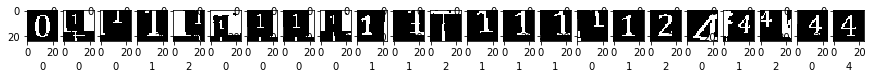

In [23]:
plt.figure(figsize=(15, 3))

for i in range(n):
    plt.subplot(1, n, i + 1)

    pic = np.reshape(x_real[i,:,:,:], (nh, nh))
    
    plt.imshow(pic, cmap='gray')
    plt.xlabel(str(y_label[i]))
    
plt.show()

## Predict with CNN model ##

In [62]:
checkpoint_path = "training_2/cp.ckpt"

model_c = create_model_c()
loss, acc = model_c.evaluate(x_real, y_real)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

model_c.load_weights(checkpoint_path)
loss, acc = model_c.evaluate(x_real, y_real)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

y_pred = model_c.predict(x_real).argmax(1)
y_label = y_pred
y_label[y_pred == 3] = 4
print(y_pred)

22/22 [==============================] - 0s 21ms/step
Untrained model, accuracy: 27.27%
22/22 [==============================] - 0s 118us/step
Restored model, accuracy: 59.09%
[0 0 0 1 4 0 1 1 0 1 4 0 1 0 0 1 2 4 4 4 4 4]


In [63]:
new_model = keras.models.load_model('./model_c.h5')
new_model.summary()

loss, acc = new_model.evaluate(x_real, y_real)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 22, 22, 8)         80        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 16)        1168      
_________________________________________________________________
flatten_23 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 25604     
Total params: 26,852
Trainable params: 26,852
Non-trainable params: 0
_________________________________________________________________
22/22 [==============================] - 0s 9ms/step
Restored model, accuracy: 59.09%


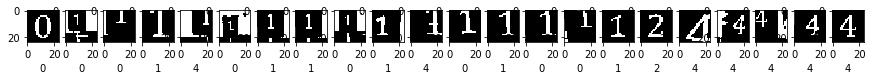

In [64]:
plt.figure(figsize=(15, 3))

for i in range(n):
    plt.subplot(1, n, i + 1)

    pic = np.reshape(x_real[i,:,:,:], (nh, nh))
    
    plt.imshow(pic, cmap='gray')
    plt.xlabel(str(y_label[i]))
    
plt.show()

In [174]:
print(len(y_train), len(y_test))

3251 813


## model ouput##

Java 调用Keras和tensorflow模型
https://www.jianshu.com/p/0016a34c82c8

In [79]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    :param session: 需要转换的tensorflow的session
    :param keep_var_names:需要保留的variable，默认全部转换constant
    :param output_names:output的名字
    :param clear_devices:是否移除设备指令以获得更好的可移植性
    :return:
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        # 如果指定了output名字，则复制一个新的Tensor，并且以指定的名字命名
        if len(output_names) > 0:
            for i in range(output_names):
                # 当前graph中复制一个新的Tensor，指定名字
                tf.identity(model.model.outputs[i], name=output_names[i])
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [110]:
from keras import backend as K
from keras.models import load_model
import tensorflow as tf

# del model

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.load_model("model.h5")
model = load_model('model.h5')

print(model.input.op.name)
print(model.output.op.name)

# 自定义output_names
frozen_graph = freeze_session(K.get_session(), output_names=["output"])
tf.train.write_graph(frozen_graph, "./", "model.pb", as_text=False)

### 输出：
# input
# output_softmax/Softmax
# 如果不自定义output_name，则生成的pb模型的output_name为output_softmax/Softmax，如果自定义则以自定义名为output_name

ValueError: You are trying to load a weight file containing 3 layers into a model with 0 layers.